## 2.1 Template Matching 
<br>
### Students: Osman Berk Satir and Milica Novakovic

## Introduction

In this warm-up section, we will address the problem of detection and recognition using Template Matching (http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html). 

Template matching is a 'brute-force' algorithm for object recognition. The most basic method of template matching is to directly compare the grayscale images, without using edge detection. For example, if you were trying to detect, let's say a football, you will need to create a base template of the object. During the operation, the template matching algorithm would analyze the current image to find areas which are similar to the template. This basic approach is quite limited. For one thing, it is not robust to inconsistent changes in brightness within the image. If the template image has strong features, a feature-based approach may be considered; the approach may prove further useful if the match in the search image might be transformed in some fashion. For templates without strong features, or for when the bulk of the template image constitutes the matching image, a template-based approach may be effective. 

In the naive approach, the difference between the template and the matching area is computed pixel by pixel and used to calculate the overall error. It is possible to reduce the number of sampling points by reducing the resolution of the search and template images by the some factor and performing the operation on the resultant downsized images (multiresolution, or Pyramid (image processing)), providing a search window of data points within the search image so that the template does not have to search every viable data point or a combination of both.



<img src="https://pythonspot-9329.kxcdn.com/wp-content/uploads/2015/05/templateMatch.jpeg">
</img>

Template matching example. Left: Template image. Right: Input image with the resulting image highlighted.  



## Section objectives: 

In this section, we will explore the advantages and disadvantages of template matching method. However, in contrast with the previous Chapter, we will leave most of the implementation for the lector (i.e. you).

The following section will introduce to the most common metrics used for the matching distance and how to are used in OpenCV. Your task will be to __a)__ Implement each metric *by hand* __b)__ compare the accuracy against the OpenCV method __c)__ Analyse and report your observations for each metric in 3 exercises and one mini-challenge.

As the final exercise, you will be given a set of more "challenging" data examples where using what you *learned before*, you will be asked to detect several objects in the scene. Your resulting algorithm __should have the given set of inputs and outputs__.



## Distance, minimums and maximums

The two (and pretty much only) important parts of the Naive Template Matching algorithm is the *distance transform*, i.e. the metric to know if we found a match or not, and the global minima detection. 

For an  Input image $I$ if size $W\times H$, a template Image $T$ of size $w\times h$; ($w<W, h<H$), the distance methods implemented in OpenCv are the following: 

* Mean Squared Difference Method=CV_TM_SQDIFF

\begin{equation*}
R(x,y)= \sum _{x',y'} (T(x',y')-I(x+x',y+y'))^2 
\end{equation*}

* Normalized Mean Squared Difference Method=CV_TM_SQDIFF_NORMED
\begin{equation*}
        R(x,y)= \frac{\sum_{x',y'} (T(x',y')-I(x+x',y+y'))^2}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}
\end{equation*}

* Cross Correlation Method=CV_TM_CCORR
\begin{equation*}
        R(x,y)= \sum _{x',y'} (T(x',y') \cdot I(x+x',y+y'))
\end{equation*}

* Normalized Cross Correlation method=CV_TM_CCORR_NORMED
\begin{equation*}
        R(x,y)= \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x',y+y'))}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}
\end{equation*}

* Correlation Coefficient Method=CV_TM_CCOEFF
\begin{equation*}
        R(x,y)= \sum _{x',y'} (T'(x',y') \cdot I'(x+x',y+y'))
\end{equation*}

where

\begin{equation*}
\begin{array}{l} T'(x',y')=T(x',y') - 1/(w \cdot h) \cdot \sum _{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w \cdot h) \cdot \sum _{x'',y''} I(x+x'',y+y'') 
\end{array}
\end{equation*}

* Normalized  Normalized Correlation Coefficient=CV_TM_CCOEFF_NORMED
\begin{equation*}
        R(x,y)= \frac{ \sum_{x',y'} (T'(x',y') \cdot I'(x+x',y+y')) }{ \sqrt{\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'} I'(x+x',y+y')^2} }
\end{equation*}


Please notice that the dimensions of the output image, $R$, will depend on how you handle the edges. The easiest way is to ser the return an output image of size $(W-w+1, H-h+1)$ 

After the function finishes the comparison, the resulting image will contain an image map with the obtained values. In OpenCV, the best matches can be found as global minimums or maximums (depending which matric you used) using the minMaxLoc() function. 

### **Exercise 2.1.1**

From the functions listed above, indicate if the best matching position is located either in the local minimums or in the maximums. 

*__Write your answer here:__*
First two functions (TM_SQDIFF AND TM_SQDIFF_NORMED) should achieve local minima when the template and the picture are the same, difference should be zero in case of perfect match. In the rest of the functions they should have a maximum values

### Exercise 2.1.2

Implement (at least 3) of the functions listed above, and use them as arguments in the base method provided

In [1]:
import cv2 as cv
import numpy as np
import os
import math
from utils import *
%matplotlib inline
from matplotlib.ticker import MaxNLocator

In [2]:
# FIXED input images to use
img_rgb  = cv.imread('../data/space-invaders_1.jpg')
img_gray = cv.imread('../data/space-invaders_1.jpg',0)
template = cv.imread('../data/template_0.png',0)


def TemplateMatching(input_image, template, distance_function):
    
    """
    Given an input image, iterates over the image and computes the distance w/r
    the template, using a given distance function. 

    :input_image:       Input image. :) 
    :template:          The Template Image.
    :distance_function  Function used to compute the distance. The function should receive a image patch 
                        and a template as inputs.
    :return:            The distance map.
    """
    W = input_image.shape[1];
    H = input_image.shape[0];
    
    w = template.shape[1];
    h = template.shape[0];

    # Output image/map
    dist_map = np.zeros((H-h+1,W-w+1), dtype=np.float32)

    # we could avoid the fors by using lambda funnctions.
    for y in range(dist_map.shape[1]):
            for x in range(dist_map.shape[0]):
                # We take just the sub-patch where to compute the distance
                holder_patch = input_image[x:x+h,y:y+w];
                # for each point we compute the distance w/r the template
                dist_map[x,y]= distance_function(holder_patch,template); 
                    
    return dist_map


__Your answer__

In [3]:
# Example:

def dummyDistance(input_image_patch, template):
    difference = np.array([ (float(x)-float(y)) for x,y in zip(template.ravel(),input_image_patch.ravel())])
    
    ssq = np.sum(difference**2)
    
    return  ssq;

#How to call it:
dist_map = TemplateMatching(img_gray,template,dummyDistance)

# Code here another 3 distance functions.

def crosscorrDistance(input_image_patch, template):
    cross_corr = np.sum(input_image_patch.astype(float)*(template.astype(float)))
    return  cross_corr;

crosscorr_dist_map = TemplateMatching(img_gray,template, crosscorrDistance)

def normcrosscorrDistance(input_image_patch, template):
    input_image_patch = input_image_patch.astype(float)
    template = template.astype(float)
    if (math.sqrt(np.sum(template*template)*np.sum(input_image_patch*input_image_patch))):
        norm_cross_corr = np.sum(input_image_patch*template)/math.sqrt(np.sum(template*template)*np.sum(input_image_patch*input_image_patch))
    else:
        norm_cross_corr = 0
    return  norm_cross_corr;

norm_crosscorr_dist_map = TemplateMatching(img_gray,template, normcrosscorrDistance)

def corrcoefDistance(input_image_patch, template):
    input_image_patch = input_image_patch.astype(float)
    template = template.astype(float)
    cross_coef = np.sum((input_image_patch-np.sum(input_image_patch)/input_image_patch.size)*(template-np.sum(template)/template.size))
    return  cross_coef;

crosscoef_dist_map = TemplateMatching(img_gray,template, corrcoefDistance)

def normcrosscoefDistance(input_image_patch, template):
    input_image_patch = input_image_patch.astype(float)
    template = template.astype(float)
    norm_cross_coef = np.sum((input_image_patch.ravel()-np.sum(input_image_patch)/input_image_patch.size)*(template.ravel()-np.sum(template)/template.size))
    if (math.sqrt(np.sum((input_image_patch.ravel()-np.sum(input_image_patch)/input_image_patch.size)*(input_image_patch.ravel()-np.sum(input_image_patch)/input_image_patch.size)))):
        norm_cross_coef = norm_cross_coef/math.sqrt(np.sum((input_image_patch.ravel()-np.sum(input_image_patch)/input_image_patch.size)*(input_image_patch.ravel()-np.sum(input_image_patch)/input_image_patch.size)))
    elif (math.sqrt(np.sum((template.ravel()-np.sum(template)/template.size)*(template.ravel()-np.sum(template)/template.size)))):
        norm_cross_coef = norm_cross_coef/math.sqrt(np.sum((template.ravel()-np.sum(template)/template.size)*(template.ravel()-np.sum(template)/template.size)))
    else: norm_cross_coef = 255.0
    return  norm_cross_coef;

norm_crosscoef_dist_map = TemplateMatching(img_gray,template, normcrosscoefDistance)

### Exercise 2.1.3 

Check your outputs by using the build-in functions in OpenCV to compute the maps for each of the methods implemented. Show in each cell: your map and the OpenCV map.

__ Your answer__

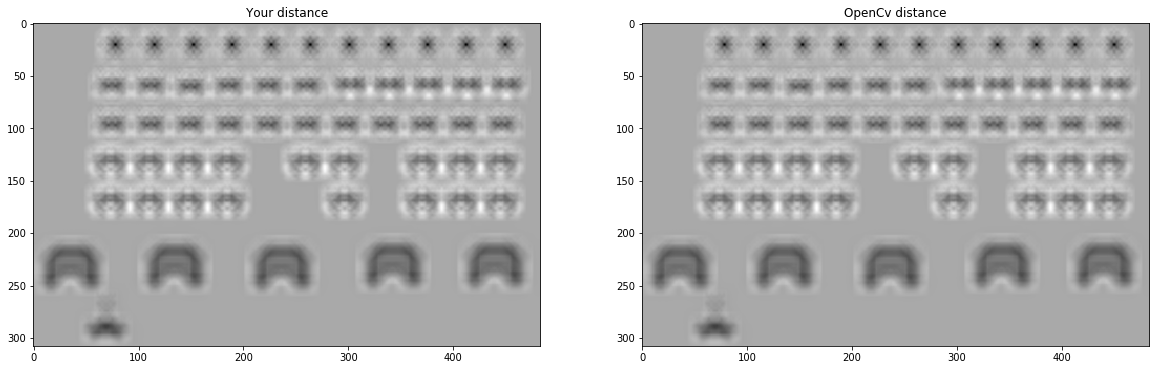

In [4]:
#your code here.

#Example:
res = cv.matchTemplate(img_gray,template,cv.TM_SQDIFF)

# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(20, 20),squeeze=False)

# Show image, add title
display_image(dist_map, axes=ax[0][0])
ax[0][0].set_title("Your distance")

display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv distance")

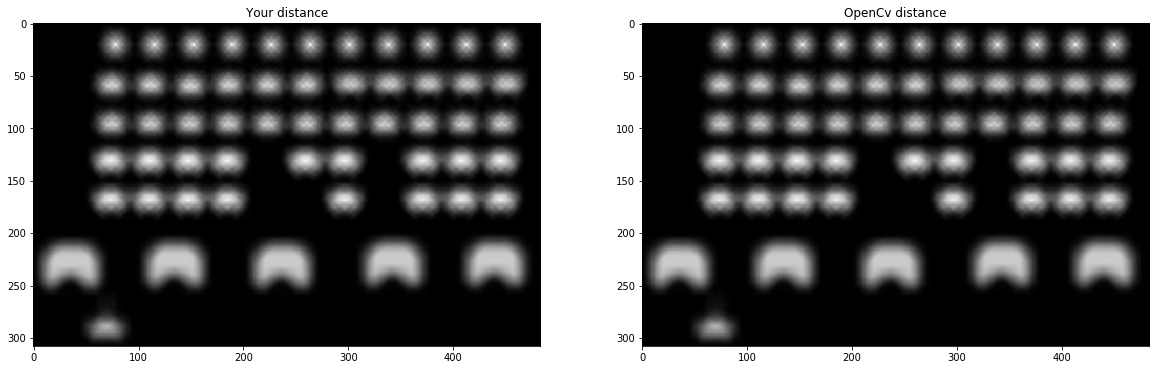

In [5]:
# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(20, 20),squeeze=False)
res = cv.matchTemplate(img_gray,template,cv.TM_CCORR)

# Show image, add title
display_image(crosscorr_dist_map, axes=ax[0][0])
ax[0][0].set_title("Your distance")

display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv distance")


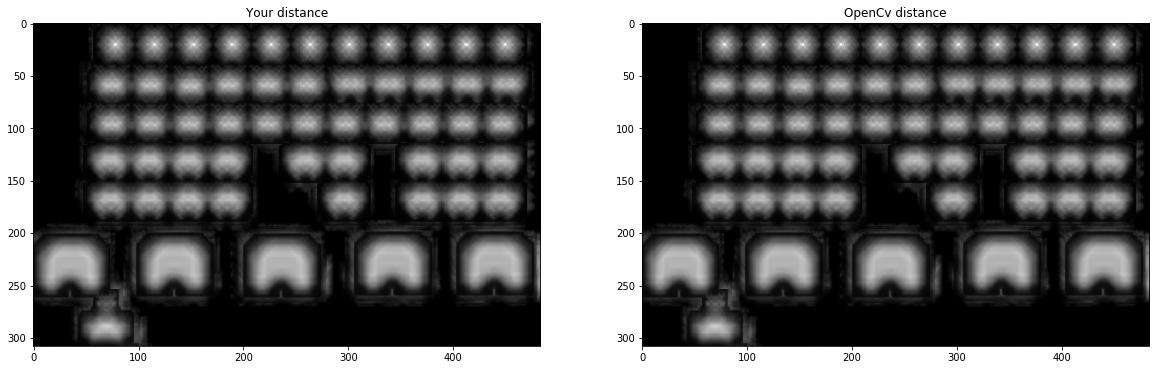

In [6]:
# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(20, 20),squeeze=False)
res = cv.matchTemplate(img_gray,template,cv.TM_CCORR_NORMED)

# Show image, add title
display_image(norm_crosscorr_dist_map, axes=ax[0][0])
ax[0][0].set_title("Your distance")

display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv distance")

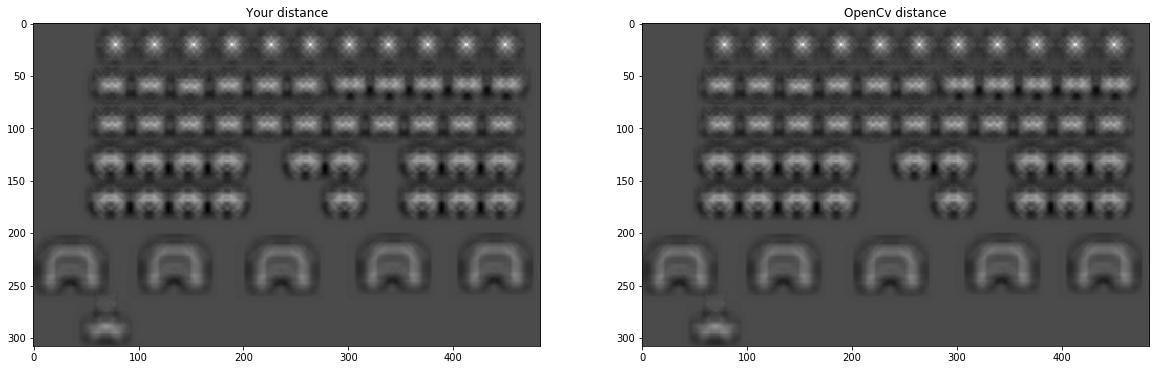

In [7]:
# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(20, 20),squeeze=False)
res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF)

# Show image, add title
display_image(crosscoef_dist_map, axes=ax[0][0])
ax[0][0].set_title("Your distance")

display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv distance")

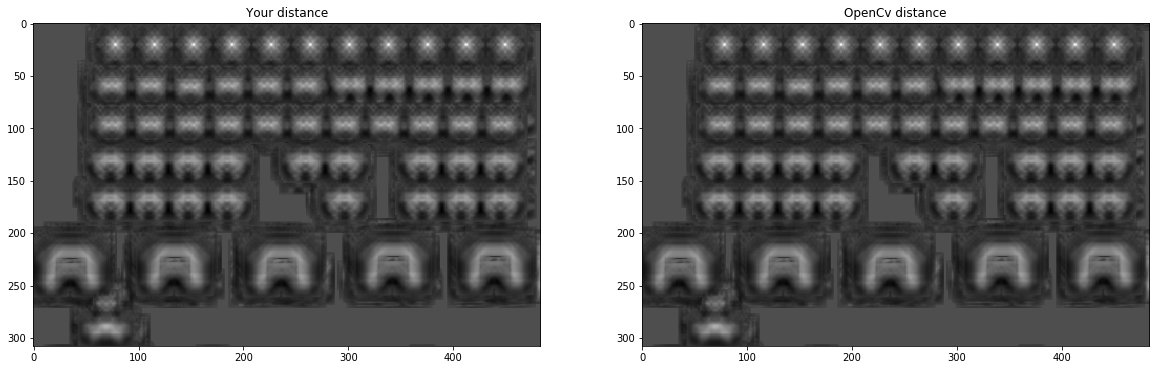

In [7]:
# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(20, 20),squeeze=False)
res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)

# Show image, add title
display_image(norm_crosscoef_dist_map, axes=ax[0][0])
ax[0][0].set_title("Your distance")

display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv distance")
plt.show()

As you may have noticed, the self-implemented method is quite slow even for small images, since it increases quadratically for the input image and also the template image. OpenCV implements the same function optimally (low-level implementation).

### Finding the local minimums/maximums

As explained before, in order to find the location of our possible object we need to find the minimum or maximum point in our resulting distance map. OpenCV minMaxLoc():

https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#void%20minMaxLoc(InputArray%20src,%20double*%20minVal,%20double*%20maxVal,%20Point*%20minLoc,%20Point*%20maxLoc,%20InputArray%20mask) ,

can be used to find the local minimum and maximum of the single-channel array (1D or 2D). 

However, if we happen to have several objects in the image that we would like to match cv.minMaxLoc() won't give you all the locations. 

### Exercise 2.1.4 

Write your own function: 

`multiMinMax(src, flag, params)`,

which should take an input 2D image `src` and return an `output_array` with the local minimums or maximums depending on the provided `flag` (`flag = "min"` or `flag = "max"`), and a given `params`.

The `params` can be, for example, a _threshold_ for the local minima/maxima, the maximum number of maximums/minimums to return, a difference between the global maxima/minima to be included, etc.



We will write simple function multiMinMax that will take three parameters as input and gives back tuple of the minimums or maximums points. The input parameters will be: src: distance matrix, flag: min or max, to know do we need to find minimums or maximums, params: thresh value in range 0 to 1 which will be used to find local minimums/maximums. Also the example of using function will be given

14


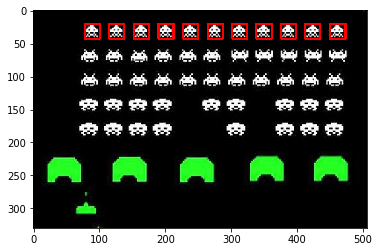

In [8]:
## Code here
# Function skeleton
def multiMinMax(src,flag,params):
    # input parameters:
    # src: distance matrix, in which we are looking minimas or maximas
    # flag: depending on nature of the distance matrix calculated and stored in src
    # flag: string min or max, describe what should we look
    # params: thresh of normalized picture that will be used to find local minimas or maximas, from range [0,1]
    dummy = []
    # normalizing the input image, in case the src image that is distance is not normalized, i.e. sqdiff
    src_copy = (src.copy()-np.min(src))/(np.max(src)-np.min(src))
    if flag=="max":
        dummy = np.where(src_copy>=params)
    elif flag=="min":
        dummy = np.where(src_copy<=params)   
    return dummy


# how to draw the ROIS
def drawROIS(src, template, locations, color = (0,0,255)):
    w, h = template.shape[::-1]
    
    img_holder = src.copy();

    for pt in zip(*locations[::-1]):
        cv.rectangle(img_holder, pt, (pt[0] + w, pt[1] + h), color, 2)
    
    return img_holder; 
    

# How should be called:
img_rgb  = cv.imread('../data/space-invaders_1.jpg')
img_gray = cv.imread('../data/space-invaders_1.jpg',0)
template = cv.imread('../data/template_0.png',0)

# For a given distance Map
distance_map_norm_corr = cv.matchTemplate(img_gray,template,cv.TM_CCORR_NORMED)

# Use your function here!
locations = multiMinMax(distance_map_norm_corr,'max',0.95)

# Draw the ROIs 
img_rgb_holder = drawROIS(img_rgb, template, locations)

# example:
display_image(img_rgb_holder)

# How many ROIS did you returned? 
print(len(locations[0]))

On this example, we can see that there are 14 detected maximums although in the image there is 11 different shape of the template. We can conclude that some of the maximums correspond to the same shape, and some of the rectangles have been multiple times drawn. To surpass this undesired behaviour we will write function multiMinMaxTemplate which will take one additional argument than multiMinMax function and that argument is template itself. The output of the function should be location of the minimums/maximums that are not overlapping each other. In case of the two overlapping rectangles, just location of the one should will be given back. We define overlapping rectangles as ones whose overlapps at least 50% of the appropriate template size in both direction.

In [9]:
def multiMinMaxTemplate(src,flag,params,tmpl):
    dummy = []
    src_copy = (src.copy()-np.min(src))/(np.max(src)-np.min(src))
    if flag=="max":
        dummy = np.where(src_copy>=params)
    elif flag=="min":
        dummy = np.where(src_copy<=params)
    y_pos = list(dummy[0])
    x_pos = list(dummy[1])
    i = 0
    j = 0
    curr_len = len(y_pos)
    while i<curr_len:
        j = i+1
        while j<curr_len:
            if ((np.abs(y_pos[j]-y_pos[i])<0.5*template.shape[0]) and (np.abs(x_pos[i]-x_pos[j])<0.5*template.shape[1])):
                y_pos[i] = int((y_pos[j]+y_pos[i])/2)
                x_pos[i] = int((x_pos[j]+x_pos[i])/2)
                del y_pos[j]
                del x_pos[j]
                curr_len-=1
            else:
                j+=1
        i+=1
    locations = (np.array(y_pos), np.array(x_pos))
    return locations

11


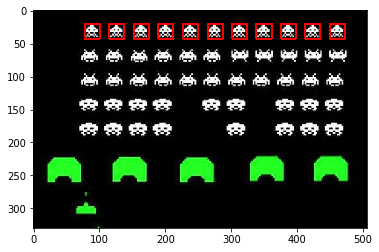

In [10]:
distance_map_norm_corr = cv.matchTemplate(img_gray,template,cv.TM_CCORR_NORMED)

# Use your function here!
locations = multiMinMaxTemplate(distance_map_norm_corr,'max',0.95, template)

# Draw the ROIs 
img_rgb_holder = drawROIS(img_rgb, template, locations)

# example:
display_image(img_rgb_holder)

# How many ROIS did you returned? 
print(len(locations[0]))

## Exercise 2.1.5: 

Now that you are all set up, use the functions above and *try* to detect ALL the matching objects in the input image (Using template Matching).

Rules:

* You can use any metric you want, self-implemented or from OpenCV. 
* You can tweak your multiMinMax to get better results.
* For 1) and 2) and 3) you have to do it in grayscale.
* 4) can use multi-channel heuristics.



### 1) Perfect match <3

Using the base input provided, plot the input image _showing_ the locations of the matching objects for the 2 provided templates.

Follow the code below and provide some insights like:

* Why did you choose that given metric?  
* How robust to false positives/negatives is your selected metric.
* Is the number of output locations the same as the matching objects? 


[]

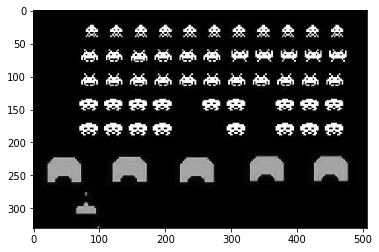

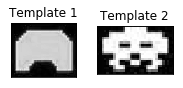

In [11]:
# input images to use
p1_src_rgb    = cv.imread('../data/space-invaders_1.jpg')
p1_src_gray   = cv.imread('../data/space-invaders_1.jpg',0)

# Show the matching of these 2 templates:
p1_template_1 = cv.imread('../data/template_1.png',0)
p1_template_2 = cv.imread('../data/template_2.png',0)

display_image(p1_src_gray)

fig, ax = plt.subplots(1, 2, figsize=(3, 1),squeeze=False)

display_image(p1_template_1, axes=ax[0][0])
ax[0][0].set_title("Template 1")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p1_template_2, axes=ax[0][1])
ax[0][1].set_title("Template 2")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

Function plot_thresh_range should plot the number of the detected matches given by locations calculated by function multiMinMaxTemplate and multiMinMax. 

In [12]:
def plot_thresh_range(distance_map, flag, template, flag_function, upper_thresh=0.99, lower_thresh=0.76, thresh_step=0.01):
    x_thresh = np.arange(lower_thresh, upper_thresh, thresh_step)
    y_location = np.zeros_like(x_thresh)
    if flag_function=="multiMinMaxTemplate":
        for ind, thresh in enumerate(x_thresh):
            locations = multiMinMaxTemplate(distance_map, flag, thresh, template)
            y_location[ind] = int(len(locations[0]))
    else:
        for ind, thresh in enumerate(x_thresh):
            locations = multiMinMax(distance_map, flag, thresh)
            y_location[ind] = int(len(locations[0]))
    ax = plt.figure().gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.scatter(x_thresh, y_location)
    plt.title("Num of detected matches as function of threshold, location by "+flag_function)

In [13]:
names_1 = list()
names_2 = list()
up_thresh_temp_1 = list()
up_thresh_temp_2 = list()
low_thresh_temp_1 = list()
low_thresh_temp_2 = list()
fn_thresh_temp_1 = list()
fn_thresh_temp_2 = list()
fp_thresh_temp_1 = list()
fp_thresh_temp_2 = list()
opt_range_temp_1 = list()
opt_range_temp_2 = list()

Now we will check outputs of the function for the distance matrix calculated by in-built function matchTemplate with argument cv.TM_CCORR_NORMED.

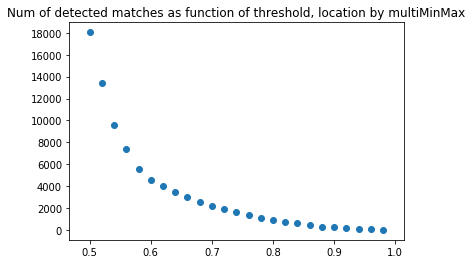

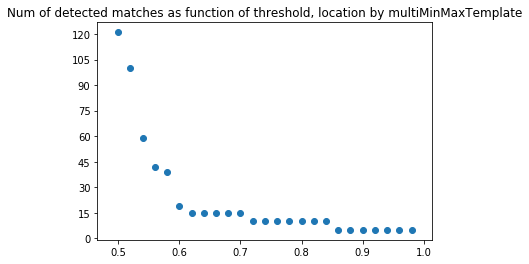

In [14]:
distance_map_norm_corr = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCORR_NORMED)

plot_thresh_range(distance_map_norm_corr, "max", p1_template_1, "multiMinMax" , upper_thresh=0.99, lower_thresh=0.5, thresh_step=0.02)
plot_thresh_range(distance_map_norm_corr, "max", p1_template_1, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.5, thresh_step=0.02)

With visual inspection we can observe number of matches of template_1 in the picture should be 5. Having in mind first plot is result of the multiMinMax function that detect each overlapping rectangle as independent matches, we could see that number of detected object explodes quickly, although it does not necessairy mean that they are different objects. In order to see which range of thresholds is optimal in terms of false positives/negatives we could conclude that first plot is not appropriate tool. 

To estimate whether for threshold 0.8 we have false positives or not, from first plot we see that we have 1000 detection, and it could trick us that we have a lot of false positives, but without visual verification we are not able to conclude anything about it. 

From the previous reasons and the fact that some of the overlapping rectangles are collapsed in one by function multiMinMaxTemplate, we expect that second plot could tell us more about optimal range of thresholds. From now and on, we will use second plot to select possible thresholds as the one after the number of detection starts to increase quickly (i.e. 0.6) in order not to detect false positive or false negatives. 

One important fact to keep in mind is that we have not get rid of all overlapping rectangels, so 10 or 15 matches can be without falses, just with location determined by multiMinMaxTemplate we reduce effect of overlapping recatangles but they still exist. 

Note that it seems that we have no problem with false negatives i.e thresh 0.99 produces 5 detections, at least it is the same number as the expected number of matches

Detected objects for low thresh: 5
Detected objects for up thresh: 5
Lower thresh optimal = 0.85
Upper thresh optimal = 0.99
Range of thresh for optimal detection = 0.14


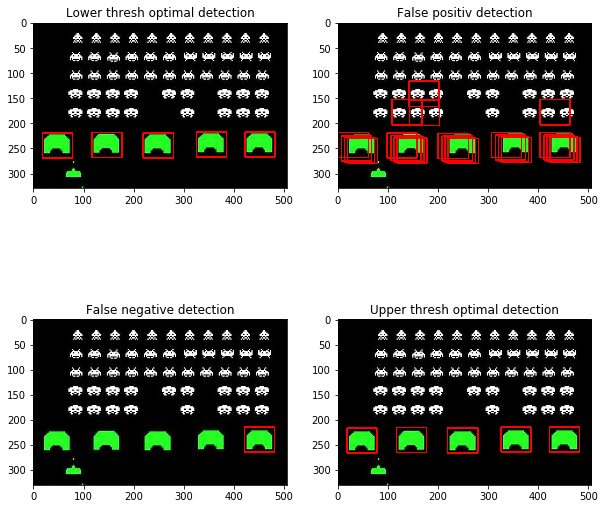

In [15]:
# For a given distance Map
distance_map_norm_corr = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCORR_NORMED)

fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.59
low_thresh = 0.85
up_thresh = 0.99
fneg_thresh = 0.99999

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_corr,'max',low_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_corr,'max',fpos_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_corr,'max',fneg_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_corr,'max',up_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1.append("cv.TM_CCORR_NORMED")
up_thresh_temp_1.append(up_thresh)
low_thresh_temp_1.append(low_thresh)
fn_thresh_temp_1.append(fneg_thresh)
fp_thresh_temp_1.append(fpos_thresh)
opt_range_temp_1.append(opt_range)

We will do follow same steps for other distances for template 1, in order to find optimal thresholds for each distance

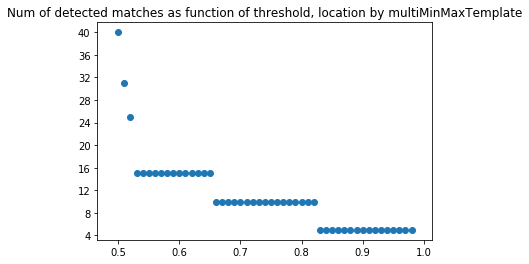

In [16]:
distance_map_corr = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCORR)
plot_thresh_range(distance_map_corr, "max", p1_template_1, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.5, thresh_step=0.01)

Detected objects for low thresh: 5
Detected objects for up thresh: 5
Lower thresh optimal = 0.83
Upper thresh optimal = 0.99
Range of thresh for optimal detection = 0.16000000000000003


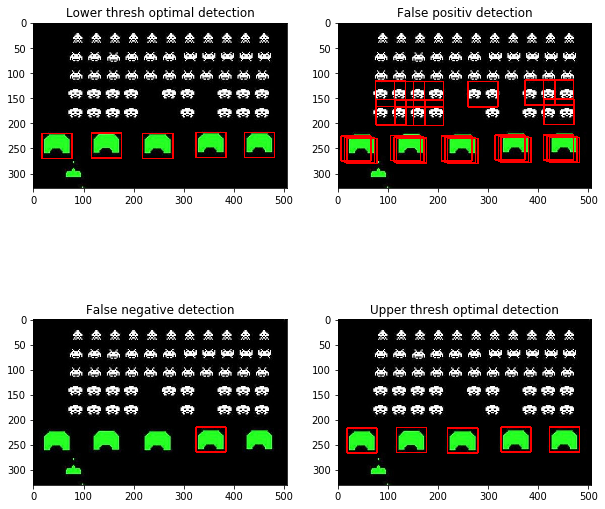

In [17]:
distance_map_corr= cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCORR)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.52
low_thresh = 0.83
up_thresh = 0.99
fneg_thresh = 0.99995

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_corr,'max',low_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_corr,'max',fpos_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_corr,'max',fneg_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_corr,'max',up_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1.append("cv.TM_CCORR")
up_thresh_temp_1.append(up_thresh)
low_thresh_temp_1.append(low_thresh)
fn_thresh_temp_1.append(fneg_thresh)
fp_thresh_temp_1.append(fpos_thresh)
opt_range_temp_1.append(opt_range)

For the distances cv.TM_CCORR_NORMED and cv.TM_CCORR we could observe that in terms of setting threshold for false positives, cv.TM_CCORR has lower value and the number of detection in range 0.5- 0.55 is slightly smaller for cv.TM_CCORR, and the same function has slighly wider range of values for optimal threshold, so on this example i would recommend cv.TM_CCORR function for detection over the cv.TM_CCORR_NORMED but they have almost same performance. Both functions practically always detects templates in this example, they are robust in terms of false negatives.

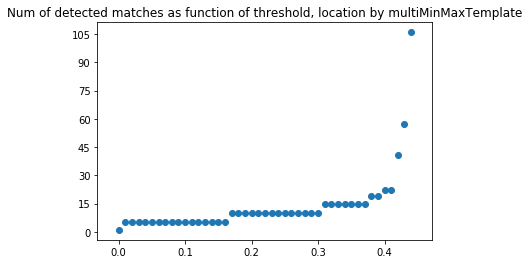

In [18]:
distance_map_square = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_SQDIFF)
plot_thresh_range(distance_map_square, "min", p1_template_1, "multiMinMaxTemplate" , upper_thresh=0.45, lower_thresh=0, thresh_step=0.01)

Detected objects for low thresh: 5
Detected objects for up thresh: 5
Lower thresh optimal = 0.01
Upper thresh optimal = 0.16
Range of thresh for optimal detection = 0.15


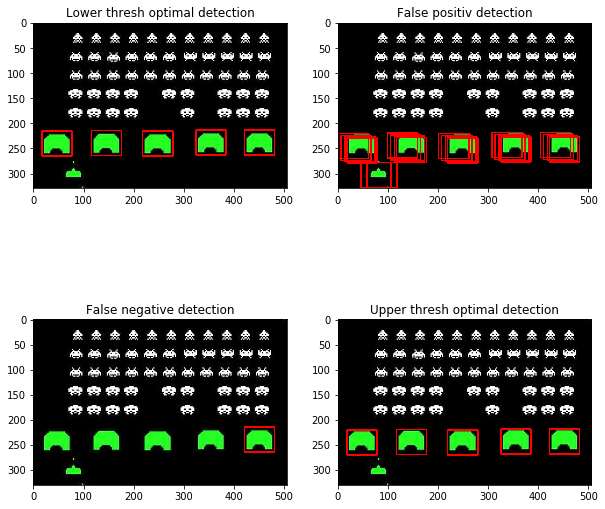

In [19]:
# For a given distance Map
distance_map_square = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_SQDIFF)

fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.4
low_thresh = 0.01
up_thresh = 0.16
fneg_thresh = 0.00001

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_square,'min',low_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_square,'min',fpos_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_square,'min',fneg_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_square,'min',up_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1.append("cv.TM_SQDIFF")
up_thresh_temp_1.append(up_thresh)
low_thresh_temp_1.append(low_thresh)
fn_thresh_temp_1.append(fneg_thresh)
fp_thresh_temp_1.append(fpos_thresh)
opt_range_temp_1.append(opt_range)

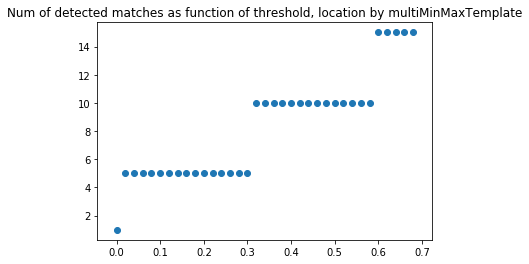

In [20]:
distance_map_norm_square = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_SQDIFF_NORMED)
plot_thresh_range(distance_map_norm_square, "min", p1_template_1, "multiMinMaxTemplate" , upper_thresh=0.7, lower_thresh=0, thresh_step=0.02)

Detected objects for low thresh: 5
Detected objects for up thresh: 5
Lower thresh optimal = 0.01
Upper thresh optimal = 0.3
Range of thresh for optimal detection = 0.29


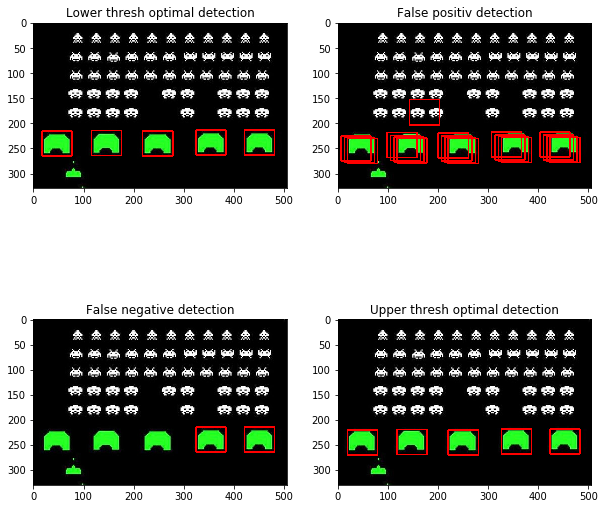

In [ ]:
distance_map_norm_square = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_SQDIFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.83
low_thresh = 0.01
up_thresh = 0.3
fneg_thresh = 0.00005

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',low_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_square,'min',fpos_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_square,'min',fneg_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',up_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1.append("cv.TM_SQDIFF_NORMED")
up_thresh_temp_1.append(up_thresh)
low_thresh_temp_1.append(low_thresh)
fn_thresh_temp_1.append(fneg_thresh)
fp_thresh_temp_1.append(fpos_thresh)
opt_range_temp_1.append(opt_range)

For the distances cv.TM_SQDIFF and cv.TM_SQDIFF_NORMED we could observe that in terms of setting threshold for false positives, cv.TM_SQDIFF_NORMED has bigger range of possible value than cv.TM_SQDIFF 0.82 compared to 0.39 , and the same function has much bigger range of values for optimal threshold 0.29 over 0.15, so on this example i would recommend cv.TM_SQDIFF_NORMED function for detection over the cv.TM_SQDIFF but they have almost same performance. Both functions practically always detects templates in this example, they are robust in terms of false negatives.

In [ ]:
distance_map_coeff = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCOEFF)
plot_thresh_range(distance_map_coeff, "max", p1_template_1, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.55, thresh_step=0.01)

In [ ]:
distance_map_coeff= cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCOEFF)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.67
low_thresh = 0.79
up_thresh = 0.99
fneg_thresh = 0.9995

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_coeff,'max',low_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_coeff,'max',fpos_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_coeff,'max',fneg_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_coeff,'max',up_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1.append("cv.TM_CCOEFF")
up_thresh_temp_1.append(up_thresh)
low_thresh_temp_1.append(low_thresh)
fn_thresh_temp_1.append(fneg_thresh)
fp_thresh_temp_1.append(fpos_thresh)
opt_range_temp_1.append(opt_range)

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", p1_template_1, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.55, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCOEFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.6
low_thresh = 0.77
up_thresh = 0.99
fneg_thresh = 0.99995

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',low_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_coeff,'max',fpos_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_coeff,'max',fneg_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',up_thresh, p1_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1.append("cv.TM_CCOEFF_NORMED")
up_thresh_temp_1.append(up_thresh)
low_thresh_temp_1.append(low_thresh)
fn_thresh_temp_1.append(fneg_thresh)
fp_thresh_temp_1.append(fpos_thresh)
opt_range_temp_1.append(opt_range)

For the distances cv.TM_CCOEFF and cv.TM_CCOEFF_NORMED we could observe that in terms of setting threshold for false positives, cv.TM_CCOEFF_NORMED has bigger range of possible value than cv.TM_CCOEFF 0.4 compared to 0.33 , and the same function has slighly bigger range of values for optimal threshold 0.22 over 0.19, so on this example i would recommend cv.TM_CCOEFF_NORMED function for detection over the cv.TM_CCOEFF. Both functions practically always detects templates in this example, they are robust in terms of false negatives

We will look at threshold values of all the distances:

In [ ]:
print("Distance names ", names_1)

print("Upper thresholds ", up_thresh_temp_1)
print("Lower thresholds ", low_thresh_temp_1)
print("False negative thresholds ", fn_thresh_temp_1)
print("False positive thresholds ", fp_thresh_temp_1)
print("Optimal threshold range ", opt_range_temp_1)

I would conclude that in terms of the biggest threshold range and margin for false positives the most appropriate function to use for first template is 'cv.TM_SQDIFF_NORMED and on the second place is 'cv.TM_CCOEFF_NORMED. The same algorithm of analysis could be conducted for the template 2, but for the sake of more compact solution for the template 2 just these two distances will be tested

In [ ]:
distance_map_norm_square = cv.matchTemplate(p1_src_gray,p1_template_2,cv.TM_SQDIFF_NORMED)
plot_thresh_range(distance_map_norm_square, "min", p1_template_2, "multiMinMaxTemplate" , upper_thresh=0.5, lower_thresh=0.01, thresh_step=0.01)

In [ ]:
distance_map_norm_square = cv.matchTemplate(p1_src_gray,p1_template_2,cv.TM_SQDIFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.40
low_thresh = 0.05
up_thresh = 0.39
fneg_thresh = 0.04

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',low_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_2, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_square,'min',fpos_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_2, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_square,'min',fneg_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_2, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',up_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_2, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_2.append("cv.TM_SQDIFF_NORMED")
up_thresh_temp_2.append(up_thresh)
low_thresh_temp_2.append(low_thresh)
fn_thresh_temp_2.append(fneg_thresh)
fp_thresh_temp_2.append(fpos_thresh)
opt_range_temp_2.append(opt_range)

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(p1_src_gray,p1_template_2,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", p1_template_2, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.5, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(p1_src_gray,p1_template_2,cv.TM_CCOEFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.74
low_thresh = 0.75
up_thresh = 0.96
fneg_thresh = 0.97

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',low_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p1_src_rgb, p1_template_2, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_coeff,'max',fpos_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p1_src_rgb, p1_template_2, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_coeff,'max',fneg_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p1_src_rgb, p1_template_2, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',up_thresh, p1_template_2)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p1_src_rgb, p1_template_2, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_2.append("cv.TM_CCOEFF_NORMED")
up_thresh_temp_2.append(up_thresh)
low_thresh_temp_2.append(low_thresh)
fn_thresh_temp_2.append(fneg_thresh)
fp_thresh_temp_2.append(fpos_thresh)
opt_range_temp_2.append(opt_range)

We will look at threshold values of all the distances for the second template:

In [ ]:
print("Distance names ", names_2)

print("Upper thresholds ", up_thresh_temp_2)
print("Lower thresholds ", low_thresh_temp_2)
print("False negative thresholds ", fn_thresh_temp_2)
print("False positive thresholds ", fp_thresh_temp_2)
print("Optimal threshold range ", opt_range_temp_2)

We would conclude that in terms of the biggest threshold range 0.34 and 0.21 and the larger margin for false positives 0.4 compared to 0.26 the better choice is 'cv.TM_SQDIFF_NORMED than the 'cv.TM_CCOEFF_NORMED. 

Compared to the results of these functions on template 1, we could see that false negative are more likely to occur. Also, there are smaller margin for false positive. These results can be explained by the fact that source image contain much more similar regions to template 2 than to template 1. 

Optimal threshold range heavely depend on the threshold values which depend on number of detected rectangles. Decisions which algorithms works better for the given template can vary depending on our implementation of the function which gives back location of minimas or maximas, in other words how we define overlapping windows (how much are percetage overlap) and do we count every or just one as the new object


### 2) Not so perfect Match </3

Plot the input image _showing_ the locations of the matching objects and any false positive. All the _invaders_ in the same row counts as the "same" class. 

Follow the code bellow and provide some insights like:

* How did you select the number of maximums/minimus?  
* How robust to false positives/negatives is your selected metric.
* Is the number of output locations the same as the matching objects? 
* Could you use any of the features from the last chapter to improve the matching?


In [ ]:
# input
p2_src_rgb    = cv.imread('../data/space-invaders_2.jpg')
p2_src_gray   = cv.imread('../data/space-invaders_2.jpg',0)

# 2 tempaltes (check that tempalte one don't match all the invaders in the same row) 
p2_template_1 = cv.imread('../data/template_3.png',0)
p2_template_2 = cv.imread('../data/template_1.png',0)

display_image(p2_src_gray)

fig, ax = plt.subplots(1, 2, figsize=(3, 1),squeeze=False)

display_image(p2_template_1, axes=ax[0][0])
ax[0][0].set_title("Template 1")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p2_template_2, axes=ax[0][1])
ax[0][1].set_title("Template 2")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])


In [ ]:
names_1_not_per = list()
up_thresh_temp_1_not_per = list()
low_thresh_temp_1_not_per = list() 
fn_thresh_temp_1_not_per = list()
fp_thresh_temp_1_not_per = list()
opt_range_temp_1_not_per = list()

names_2_not_per = list()
up_thresh_temp_2_not_per = list()
low_thresh_temp_2_not_per = list() 
fn_thresh_temp_2_not_per = list()
fp_thresh_temp_2_not_per = list()
opt_range_temp_2_not_per = list()

We will observe outputs of two so far best distance matrix on new templates matching, first we will determine matrix for first template

In [ ]:
distance_map_norm_square = cv.matchTemplate(p2_src_gray,p2_template_1,cv.TM_SQDIFF_NORMED)
plot_thresh_range(distance_map_norm_square, "min", p2_template_1, "multiMinMaxTemplate" , upper_thresh=0.5, lower_thresh=0.01, thresh_step=0.01)

In [ ]:
distance_map_norm_square = cv.matchTemplate(p2_src_gray, p2_template_1,cv.TM_SQDIFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.3
low_thresh = 0.08
up_thresh = 0.29
fneg_thresh = 0.07

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',low_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p2_src_rgb, p2_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_square,'min',fpos_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p2_src_rgb, p2_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_square,'min',fneg_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p2_src_rgb, p2_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',up_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p2_src_rgb, p2_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1_not_per.append("cv.TM_SQDIFF_NORMED")
up_thresh_temp_1_not_per.append(up_thresh)
low_thresh_temp_1_not_per.append(low_thresh)
fn_thresh_temp_1_not_per.append(fneg_thresh)
fp_thresh_temp_1_not_per.append(fpos_thresh)
opt_range_temp_1_not_per.append(opt_range)

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(p2_src_gray,p2_template_1,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", p2_template_1, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.5, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(p2_src_gray,p2_template_1,cv.TM_CCOEFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.79
low_thresh = 0.8
up_thresh = 0.95
fneg_thresh = 0.96

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',low_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p2_src_rgb, p2_template_1, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_coeff,'max',fpos_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p2_src_rgb, p2_template_1, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_coeff,'max',fneg_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p2_src_rgb, p2_template_1, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',up_thresh, p2_template_1)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p2_src_rgb, p2_template_1, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_1_not_per.append("cv.TM_CCOEFF_NORMED")
up_thresh_temp_1_not_per.append(up_thresh)
low_thresh_temp_1_not_per.append(low_thresh)
fn_thresh_temp_1_not_per.append(fneg_thresh)
fp_thresh_temp_1_not_per.append(fpos_thresh)
opt_range_temp_1_not_per.append(opt_range)

Now we will look at the threshold parameters for two distance

In [ ]:
print("Distance names ", names_1_not_per)

print("Upper thresholds ", up_thresh_temp_1_not_per)
print("Lower thresholds ", low_thresh_temp_1_not_per)
print("False negative thresholds ", fn_thresh_temp_1_not_per)
print("False positive thresholds ", fp_thresh_temp_1_not_per)
print("Optimal threshold range ", opt_range_temp_1_not_per)

For the not perfect template_1 we can see that function cv.TM_SQDIFF_NORMED gives larger optimal range, and also smaller interval for flase positives 0.7 compared to 0.79 which is good, but larger interval for false negatives 0.07 compared to 0.04, but if we want to penalize tendency to have false negatives, we would choose 'cv.TM_CCOEFF_NORMED'. 

Now we will try to find distance for not perfect template 2

In [ ]:
distance_map_norm_square = cv.matchTemplate(p2_src_gray,p2_template_2,cv.TM_SQDIFF_NORMED)
plot_thresh_range(distance_map_norm_square, "min", p2_template_2, "multiMinMaxTemplate" , upper_thresh=0.5, lower_thresh=0.01, thresh_step=0.01)

In [ ]:
distance_map_norm_square = cv.matchTemplate(p2_src_gray, p2_template_2,cv.TM_SQDIFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.83
low_thresh = 0.27
up_thresh = 0.3
fneg_thresh = 0.26

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',low_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p2_src_rgb, p2_template_2, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_square,'min',fpos_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p2_src_rgb, p2_template_2, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_square,'min',fneg_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p2_src_rgb, p2_template_2, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_square,'min',up_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p2_src_rgb, p2_template_2, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_2_not_per.append("cv.TM_SQDIFF_NORMED")
up_thresh_temp_2_not_per.append(up_thresh)
low_thresh_temp_2_not_per.append(low_thresh)
fn_thresh_temp_2_not_per.append(fneg_thresh)
fp_thresh_temp_2_not_per.append(fpos_thresh)
opt_range_temp_2_not_per.append(opt_range)

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(p2_src_gray,p2_template_2,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", p2_template_2, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.6, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(p2_src_gray,p2_template_2,cv.TM_CCOEFF_NORMED)
fig, ax = plt.subplots(2, 2, figsize=(10, 10),squeeze=False)

# value from the second graph and trial and error method
fpos_thresh = 0.6
low_thresh = 0.77
up_thresh = 0.83
fneg_thresh = 0.94

opt_range = up_thresh-low_thresh

locations_low_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',low_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_low_thresh = drawROIS(p2_src_rgb, p2_template_2, locations_low_thresh)
ax[0][0].set_title("Lower thresh optimal detection")
display_image(p1_rgb_holder_low_thresh, axes=ax[0][0])


# False positive
locations_fal_pos = multiMinMaxTemplate(distance_map_norm_coeff,'max',fpos_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_pos = drawROIS(p2_src_rgb, p2_template_2, locations_fal_pos)
ax[0][1].set_title("False positiv detection")
display_image(p1_rgb_holder_fal_pos, axes=ax[0][1])


locations_fal_neg = multiMinMaxTemplate(distance_map_norm_coeff,'max',fneg_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_fal_neg = drawROIS(p2_src_rgb, p2_template_2, locations_fal_neg)
ax[1][0].set_title("False negative detection")
display_image(p1_rgb_holder_fal_neg, axes=ax[1][0])


locations_up_thresh = multiMinMaxTemplate(distance_map_norm_coeff,'max',up_thresh, p2_template_2)
# Draw the ROIs 
p1_rgb_holder_up_thresh = drawROIS(p2_src_rgb, p2_template_2, locations_up_thresh)
ax[1][1].set_title("Upper thresh optimal detection")
display_image(p1_rgb_holder_up_thresh, axes=ax[1][1])

# How many ROIS did you returned? 
print("Detected objects for low thresh: "+str(len(locations_low_thresh[0])))
print("Detected objects for up thresh: "+str(len(locations_up_thresh[0])))
print("Lower thresh optimal = "+str(low_thresh))
print("Upper thresh optimal = "+str(up_thresh))
print("Range of thresh for optimal detection = "+str(opt_range))

# store the data in list
names_2_not_per.append("cv.TM_CCOEFF_NORMED")
up_thresh_temp_2_not_per.append(up_thresh)
low_thresh_temp_2_not_per.append(low_thresh)
fn_thresh_temp_2_not_per.append(fneg_thresh)
fp_thresh_temp_2_not_per.append(fpos_thresh)
opt_range_temp_2_not_per.append(opt_range)

In [ ]:
print("Distance names ", names_2_not_per)

print("Upper thresholds ", up_thresh_temp_2_not_per)
print("Lower thresholds ", low_thresh_temp_2_not_per)
print("False negative thresholds ", fn_thresh_temp_2_not_per)
print("False positive thresholds ", fp_thresh_temp_2_not_per)
print("Optimal threshold range ", opt_range_temp_2_not_per)

We can notice that function 'cv.TM_CCOEFF_NORMED has larger optimal range and smaller interval for false negatives 0.06 compared to 0.26 which is positive but there is larger interval of thresholds for which fpositives can occur 0.6 compared to 0.17, so if one wants to penalize false negatives cv.TM_CCOEFF_NORMED is appropriate function, while if does not want a lot of false positive cv.TM_SQDIFF_NORMED is good.

For both not perfect templates we would work with cv.TM_CCOEFF_NORMED due to the assumtion that robustness could be measured with optimal threshold range, and that we see all rectangles with half of height/widht overlap as one

As a conclusion we will notice that cv.TM_SQDIFF_NORMED works better on perfect templates, while on not perfect ones cv.TM_SQDIFF_NORMED and cv.TM_SQDIFF_CCOEFF has similar performance although cv.TM_SQDIFF_CCOEFF prevents false negatives, while it is recommended to use cv.TM_SQDIFF_NORMED if one prevents false positives.

Now we will ilustrate how distance is working on one specific pair of values from optimal ranges for both of templates

In [ ]:
distance_map_norm_coeff_1 = cv.matchTemplate(p2_src_gray,p2_template_1,cv.TM_CCOEFF_NORMED)

# Use your function here!
locations_1 = multiMinMaxTemplate(distance_map_norm_coeff_1,'max',0.9,p2_template_1)

# How many ROIS did you returned? 
print("multiMinMaxTemplate function returned: "+str(len(locations_1[0]))+" regions for template 1")

distance_map_norm_coeff_2 = cv.matchTemplate(p2_src_gray,p2_template_2,cv.TM_CCOEFF_NORMED)

# Use your function here!
locations_2 = multiMinMaxTemplate(distance_map_norm_coeff_2,'max',0.8,p2_template_2)

# How many ROIS did you returned? 
print("multiMinMaxTemplate function returned: "+str(len(locations_2[0]))+" regions for template 2")

p2_result = p2_src_rgb
p2_result = drawROIS(p2_result, p2_template_1,locations_1);
p2_result = drawROIS(p2_result, p2_template_2,locations_2,(255,255,0));

display_image(p2_result)

### 3) Find Waldo.

Finding Waldo (or Wally for our Brittish friends) it's a series of children's puzzle books from back in the 80's. Something like finding Nemo, but harder. In this exercise, you will try to find Waldo using template matching. 

Using the given template (beautifully cut from the input source) use it to find Waldo. 
Plot the input image _showing_ the location of Waldo (if you find it) and any false positive negative. 

In this exercise, you may choose to use any transformation in the input image (like the scale it to save time) or tweak the distance metric. 

You can't modify the template (only scale it).

Follow the code below and provide some insights like:

* What metric seemed to work better this time? 
* Was it different from the previous exercise?
* Could you use any of the features from the last chapter to improve the matching?
* How could you reduce the false positives? 

Save the output in a separate image to visualize easier.


In [ ]:
# inputs
p3_src_rgb  = cv.imread('../data/finding_waldo_1.jpg')
p3_src_gray = cv.imread('../data/finding_waldo_1.jpg',0)
p3_template = cv.imread('../data/waldo_template.jpg',0)
fig, ax = plt.subplots(1, 2, figsize=(20, 3),squeeze=False)

# size = cv.GetSize(p3_template)
# thumbnail = cv.CreateImage(( size[0] / 10, size[1] / 10), im.depth, im.nChannels)
# template_res = cv.Resize(im, thumbnail)

display_image(p3_src_rgb, axes=ax[0][0])
ax[0][0].set_title("Input")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p3_template, axes=ax[0][1])
ax[0][1].set_title("Template")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

With the assumption that given template is not a perfect match and that we want to prevent false positives, using the conclusion from the previous part we will use cv.TM_CCOEFF_NORMED as a distance measure

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(p3_src_gray,p3_template,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", p3_template, "multiMinMaxTemplate" , upper_thresh=0.99, lower_thresh=0.85, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(p3_src_gray,p3_template,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", p3_template, "multiMinMax" , upper_thresh=0.99, lower_thresh=0.95, thresh_step=0.01)

In [ ]:
#your code goes here
distance_map_norm_coeff= cv.matchTemplate(p3_src_gray,p3_template,cv.TM_CCOEFF_NORMED)

thresh_val = 0.97
# Use your function here!
# We will use the function multiMinMax which gives location of the each detected object, although multiMinMaxTemplate 
p3_locations= multiMinMax(distance_map_norm_coeff,'max',thresh_val)

p3_result = p3_src_rgb
p3_result = drawROIS(p3_result, p3_template, p3_locations,(255,255,0));

display_image(p3_result)

# How many false positives did you get?
print(len(p3_locations[0]))

Note that we detect the one single non-overlap Waldo in the picture with location calculated by multiMinMax. For the improvement of false positives, although we skip them with careful initialization of thresh, one could use function multiMinMaxTemplate which collapse overlapping windows into one, and thus reduce number of false positives

In [ ]:
## Save the output image to make it easier to visualize!!. Submit this with the notebook

cv.imwrite('../../p3_res_W1.png',p3_result)

### 4) Find Waldo 2.0.

As you can see, using template matching can be tricky, even when you have a _good_ template. As for the last exercise, you will try to design a good __template__  (it can be done in Paint if you want =P) in order to find Waldo in three different images. In this exercise, you can (if you want) use the information of the 3 RGB channels (to generate a 1 _better_ 1 channel image for example) and transform the input image (for example to homogenize the scale!).

Plot your selected template and the input image _showing_ the location of each Waldo (if you find it) and any false positive.

Follow the code below and provide some insights like:

* Was it different from the previous exercise?
* Could you perform better if you could use more than 1 template to find Waldo? 

In [ ]:
src_images = ["../data/waldo_1.jpg","../data/waldo_2.jpg","../data/waldo_3.jpg"]
loc_images = ["../data/location_1.png","../data/location_2.png","../data/location_3.png"]

src_color = []
src_gray  = []

locations = []
for img in src_images:
    src_color.append(cv.imread(img))
    src_gray.append(cv.imread(img,0))
    
for loc in loc_images:
    locations.append(cv.imread(loc))

    
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
      
    # Show image, add title + remove tick
    display_image(src_color[i], axes=ax[i][0])
    ax[i][0].set_title("Waldo %d"%i)
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    display_image(locations[i], axes=ax[i][1])
    ax[i][1].set_title("Location %d"%i)
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    

## Your code goes here.


We have made waldo template as a linear combination of the face regions from three available source images in which we will later try to find Waldo. Intermediate templates are made in photographic tool Paint, and all of them have the same size. We should inform you that we carefully tweak the weights of the intermediate templates in the main one. The waldo_2_template is already blurred, while other templates are not, so instead of resizing source images and or blurring the templates waldo_1_template and waldo_3_template, we have choosen to try to put more weights in the blurred version in order to achieve solution with as less as possible pre-processing tasks.

In [ ]:
waldo_1_template = cv.imread('location1_template.png')
waldo_2_template = cv.imread('location2_template.png')
waldo_3_template = cv.imread('location3_template.png')

waldo_temp = np.zeros_like(waldo_1_template)
waldo_temp = (0.3*waldo_1_template + 0.4*waldo_2_template + 0.3*waldo_3_template)
waldo_temp = waldo_temp.astype(np.uint8)

display_image(waldo_temp)

Indeed, the template is already blurred, so we will try to use as unique template. We will try to match each color channel of template with source image.

Having in mind the fact our template is not perfect match for any of those pictures we will use distance cv.TM_CCOEFF_NORMED. Therefore, we could deduce that each component of intermediate templates in our template should give us maximum of distance because this component of template is in highest correlation with itself which is part of the source image.

We will try to find optimal threshold such that we have only one Waldo detection, for each source image we will calculate threshold, with taking into account plots of number of matches with respect of thresh value

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(src_color[0],waldo_temp,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", waldo_temp, "multiMinMax" , upper_thresh=0.99, lower_thresh=0.8, thresh_step=0.01)

We will pick thresh as the smallest one for which we have one unique match

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(src_color[0],waldo_temp,cv.TM_CCOEFF_NORMED)

thresh_val = 0.9
# Use your function here!
p1_locations= multiMinMax(distance_map_norm_coeff,'max',thresh_val)

ploc1_result = src_color[0]
ploc1_result = drawROIS(ploc1_result, waldo_temp[:,:,0], p1_locations,(255,255,255))

plt.figure(figsize=(15,15))
display_image(ploc1_result)

# How many false positives did you get?
print(len(p1_locations[0]))
cv.imwrite('p3_res_W2.png',ploc1_result)

We will perform same steps to calculate optimal thresh value for second image

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(src_color[1],waldo_temp,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", waldo_temp, "multiMinMax" , upper_thresh=0.99, lower_thresh=0.9, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(src_color[1],waldo_temp,cv.TM_CCOEFF_NORMED)

thresh_val = 0.95
# Use your function here!
p2_locations= multiMinMax(distance_map_norm_coeff,'max', thresh_val)

ploc2_result = src_color[1]
ploc2_result = drawROIS(ploc2_result, waldo_temp[:,:,0], p2_locations,(155,255,0));
plt.figure(figsize=(15,15))
display_image(ploc2_result)

# How many false positives did you get?
print(len(p2_locations[0]))
cv.imwrite('p3_res_W3.png',ploc2_result)

We will perform same steps to calculate optimal thresh value for last image

In [ ]:
distance_map_norm_coeff = cv.matchTemplate(src_color[2],waldo_temp,cv.TM_CCOEFF_NORMED)
plot_thresh_range(distance_map_norm_coeff, "max", waldo_temp, "multiMinMax" , upper_thresh=0.99, lower_thresh=0.95, thresh_step=0.01)

In [ ]:
distance_map_norm_coeff= cv.matchTemplate(src_color[2],waldo_temp,cv.TM_CCOEFF_NORMED)

thresh_val = 0.99
# Use your function here!
p3_locations= multiMinMax(distance_map_norm_coeff,'max',thresh_val)

ploc3_result = src_color[2]
ploc3_result = drawROIS(ploc3_result, waldo_temp[:,:,0], p3_locations,(155,255,0));
plt.figure(figsize=(15,15))
display_image(ploc3_result)

# How many false positives did you get?
print(len(p3_locations[0]))
cv.imwrite('p3_res_W4.png',ploc3_result)

We have not had the problem with false positives, and we have used simple function multiMinMax to get location of local minimas aor maximas in the distance measure. If one had problem with false positives we recommend to use multiMinMaxTemplate function. Although it is posiblle to obtain Waldo detection with template matching we believe that our approach is not robust with respect to threshold values and weights of each template in common template